## Joseph Rocha<br> CS6463 Deep Learning<br> Dr. Amanda Fernandez<br> Fall 2019

<h1 style="text-align: center;"> DeepStruct </h1>
<h2 style="text-align: center;">Protein Secondary Structure Prediction using RNNs. </h2>

In [1]:
import numpy as np
import pandas as pd
from random import random
import gzip
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Masking
from keras.regularizers import l2
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Using TensorFlow backend.


# Load in Validation and Training Datasets

In [7]:
file = gzip.GzipFile("cullpdb+profile_5926_filtered.npy.gz", "r")
pdbs = np.load(file)
data = pdbs.reshape((len(pdbs), 700, 57))
x = data[:, :, 0:21]
y = data[:, :, 22:30]
print("Total Training Datapoints = {} ".format(len(data)))
print("Training Inputs Shape = {}".format(x.shape))
print("Training Outputs Shape = {}".format(y.shape))

5365
(5365, 700, 21)
(5365, 700, 8)


In [8]:
test_file = gzip.GzipFile("cb513+profile_split1.npy.gz", "r")
test_pdbs = np.load(test_file)
test_data = test_pdbs.reshape((514, 700, 57))
test_x = test_data[:, :, 0:21]
test_y = test_data[:, :, 22:30]
print("Total Testing Datapoints = {} ".format(len(data)))
print("Testing Inputs Shape = {}".format(x.shape))
print("Testing Outputs Shape = {}".format(y.shape))

514
(514, 700, 21)
(514, 700, 8)


# Datasets Exploratory Analysis

## Class/Label Distribution

In [110]:
freq = {}

classConvert = {
    "3": "3-10 Helix",
    "5": "Alpha Helix",
    "4": "Pi Helix",
    "2": "Beta Strand",
    "1": "Beta Bridge",
    "7": "Beta-Turn",
    "6": "Bend",
    "0": "Loop"
}


for i in y:
    for j in i:
        #Break if we enter padding section 
        if(np.array_equal(j, [0, 0, 0, 0, 0, 0, 0, 0])):
            break
        
        #Find the class of the amino acid
        aaStruct = classConvert[str(np.argmax(j))]
        
        #Count the occurance of the class
        if aaStruct in freq:
            freq[aaStruct] += 1
        else:
            freq[aaStruct] = 1
            

In [113]:
classDf = pd.DataFrame(freq, index=[0]).T.reset_index()
classDf

,index,0
0,Loop,221211
1,Beta Strand,250804
2,Bend,95133
3,Alpha Helix,399879
4,Beta-Turn,130186
5,3-10 Helix,45155
6,Beta Bridge,11832
7,Pi Helix,212


Text(0.5, 1.0, 'Dataset Class Distribution')

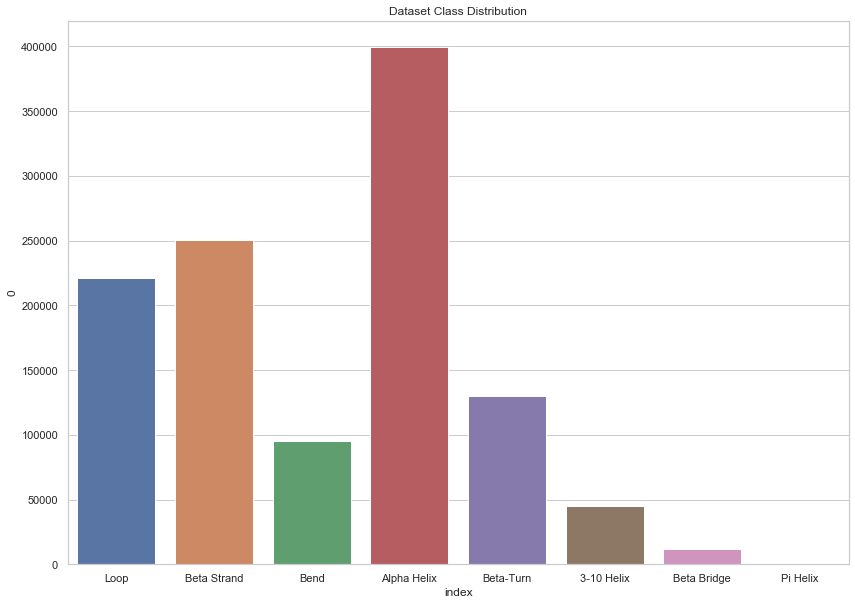

In [121]:
sns.set(style="whitegrid")
classDistribution = sns.barplot(x="index", y=0, data=classDf).set_title("Dataset Class Distribution")
fig.savefig('classdistribution.png', dpi=1200)

## Average Protein Length

In [161]:
lengths = []


for i in y:
    total_length = 0
    for j in i:
        #Break if we enter padding section 
        if(np.array_equal(j, [0, 0, 0, 0, 0, 0, 0, 0])):
            break
        total_length+=1
    lengths.append(total_length)

[315,
 148,
 344,
 75,
 122,
 191,
 261,
 204,
 95,
 314,
 145,
 135,
 342,
 90,
 103,
 513,
 238,
 135,
 425,
 186,
 153,
 347,
 123,
 115,
 175,
 205,
 172,
 119,
 176,
 68,
 290,
 268,
 376,
 263,
 78,
 278,
 34,
 89,
 211,
 233,
 115,
 182,
 179,
 208,
 261,
 208,
 337,
 264,
 241,
 170,
 313,
 330,
 602,
 59,
 92,
 245,
 84,
 62,
 547,
 433,
 233,
 301,
 352,
 392,
 617,
 299,
 80,
 144,
 131,
 119,
 149,
 191,
 253,
 337,
 245,
 141,
 98,
 74,
 121,
 400,
 370,
 84,
 142,
 176,
 105,
 190,
 177,
 142,
 516,
 152,
 136,
 125,
 661,
 77,
 261,
 201,
 206,
 106,
 424,
 189,
 157,
 144,
 136,
 239,
 145,
 77,
 263,
 385,
 265,
 52,
 94,
 265,
 373,
 90,
 111,
 171,
 437,
 411,
 63,
 221,
 302,
 222,
 149,
 273,
 457,
 264,
 47,
 126,
 464,
 358,
 157,
 372,
 118,
 190,
 130,
 79,
 89,
 381,
 241,
 355,
 243,
 160,
 192,
 232,
 289,
 110,
 196,
 312,
 156,
 157,
 73,
 204,
 115,
 431,
 75,
 370,
 441,
 171,
 251,
 126,
 239,
 227,
 109,
 100,
 137,
 192,
 128,
 646,
 193,
 212,
 59,
 

In [168]:
lengthDf = pd.DataFrame({"Protein Lengths": lengths})

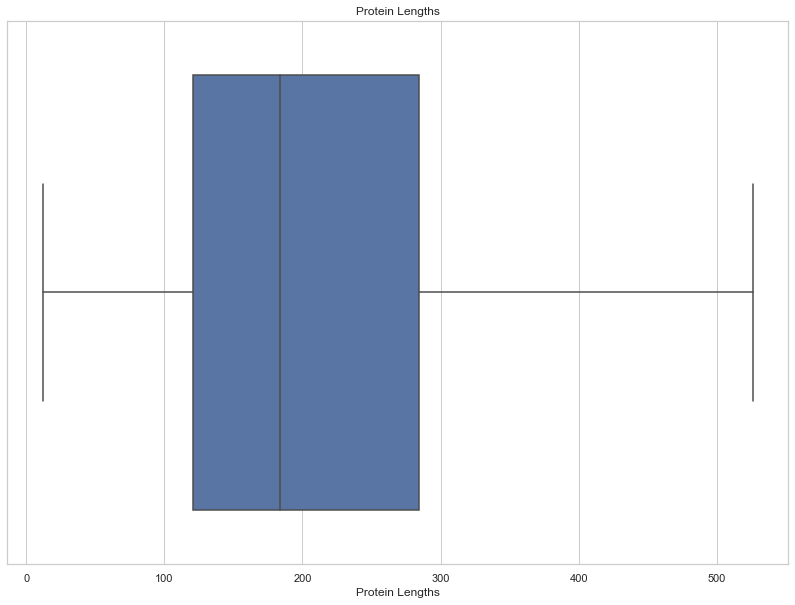

In [174]:
sns.set(style="whitegrid")
proteinLengths = sns.boxplot(x="Protein Lengths", data=lengthDf, showfliers = False).set_title("Protein Lengths")
proteinLengths.figure.savefig('proteinLengths.png', dpi=1200)

In [172]:
lengthDf.describe()

,Protein Lengths
count,5365.000000
mean,215.174651
std,124.001196
min,12.000000
25%,121.000000
50%,184.000000
75%,284.000000
max,696.000000


# DeepStruct Model Candidate 1
## - Best Validation Accuracy is 56.01%

In [71]:
# define LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(700, 21)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add((Dense(16)))
model.add((Dense(32)))
model.add((Dense(64)))
model.add((Dense(128)))
model.add((Dense(64)))
model.add((Dense(32)))
model.add((Dense(16)))
model.add((Dense(8, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',  'mae'])

In [72]:
history = model.fit(x, y, epochs=35, validation_data = (test_x, test_y), batch_size=32)

Train on 5365 samples, validate on 514 samples
Epoch 1/35
5365/5365 [==============================] - 249s 46ms/step - loss: 0.4546 - acc: 0.4396 - mae: 0.1731 - val_loss: 0.3339 - val_acc: 0.4656 - val_mae: 0.1637
Epoch 2/35
5365/5365 [==============================] - 229s 43ms/step - loss: 0.4143 - acc: 0.4996 - mae: 0.1594 - val_loss: 0.3241 - val_acc: 0.4896 - val_mae: 0.1616
Epoch 3/35
5365/5365 [==============================] - 228s 42ms/step - loss: 0.4032 - acc: 0.5173 - mae: 0.1550 - val_loss: 0.3180 - val_acc: 0.4984 - val_mae: 0.1593
Epoch 4/35
5365/5365 [==============================] - 241s 45ms/step - loss: 0.3932 - acc: 0.5314 - mae: 0.1511 - val_loss: 0.3139 - val_acc: 0.5086 - val_mae: 0.1564
Epoch 5/35
5365/5365 [==============================] - 228s 42ms/step - loss: 0.3883 - acc: 0.5386 - mae: 0.1492 - val_loss: 0.3133 - val_acc: 0.5080 - val_mae: 0.1566
Epoch 6/35
5365/5365 [==============================] - 226s 42ms/step - loss: 0.3847 - acc: 0.5423 - mae: 0

In [127]:
model.save_weights("models/DeepStructModelCandidate1.h5")
file = open("models/DeepStructModelCandidate1.history", "wb+")
pickle.dump(history.history, file)

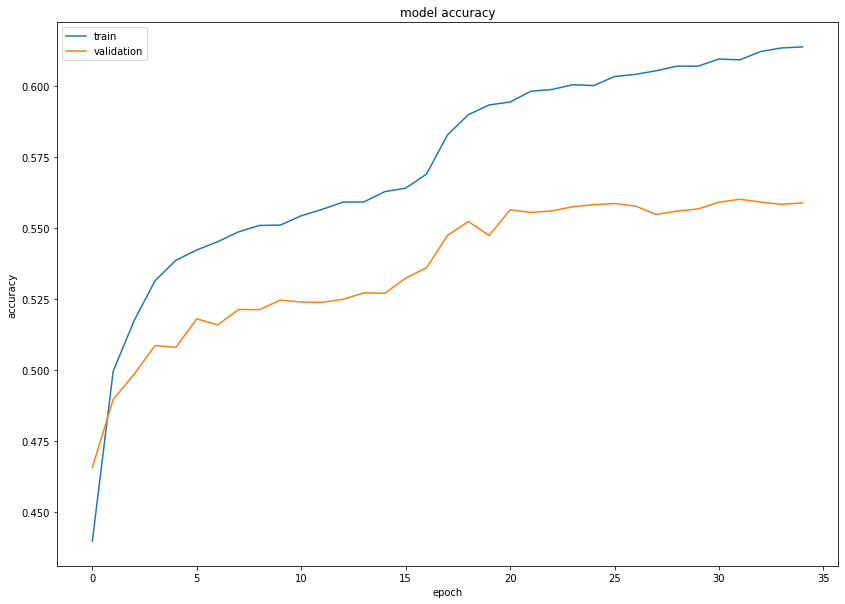

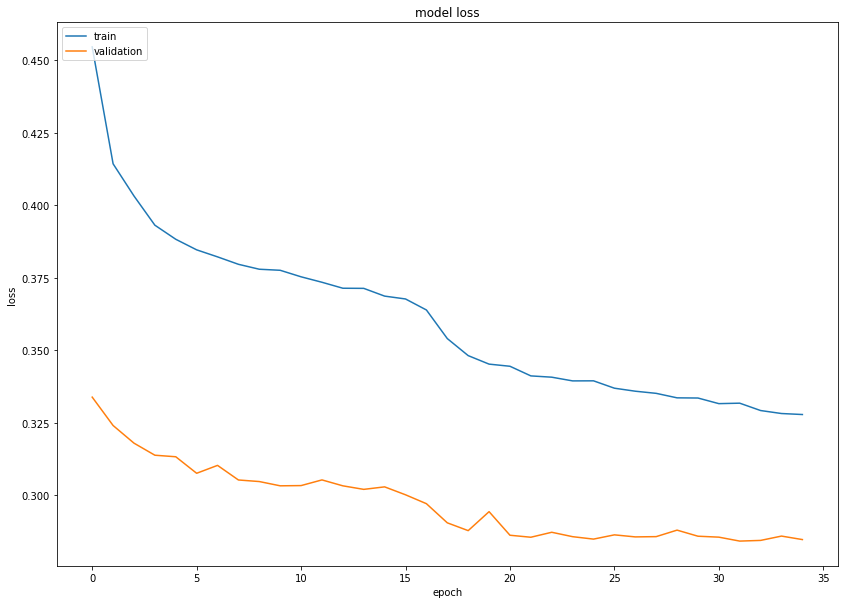

In [87]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

# "Accuracy"
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config1Accuracy.png', dpi=1200)

# "Loss"
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config1Loss.png', dpi=1200)

# DeepStruct Model Candidate 2
## - Best Validation Accuracy is 56.47%
Overfitting is more clear on this model, use regularization on next.
<br>It appears I cannot use Mask with Conv1D... rip.
<br> Might be a solution? https://groups.google.com/forum/#!topic/keras-users/KfoTsCHldM4

In [129]:
# define LSTM
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(700, 21)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add((Dense(64)))
model.add((Dense(128)))
model.add((Dense(64)))
model.add((Dense(32)))
model.add((Dense(16)))
model.add((Dense(8, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',  'mae'])

In [130]:
history = model.fit(x, y, epochs=35, validation_data = (test_x, test_y), batch_size=32)
model.save_weights("models/DeepStructModelCandidate2.h5")
file = open("models/DeepStructModelCandidate2.history", "wb+")
pickle.dump(history.history, file)

Train on 5365 samples, validate on 514 samples
Epoch 1/35
5365/5365 [==============================] - 493s 92ms/step - loss: 0.4416 - acc: 0.4591 - mae: 0.1689 - val_loss: 0.3288 - val_acc: 0.4754 - val_mae: 0.1645
Epoch 2/35
5365/5365 [==============================] - 485s 90ms/step - loss: 0.4077 - acc: 0.5105 - mae: 0.1570 - val_loss: 0.3229 - val_acc: 0.4890 - val_mae: 0.1644
Epoch 3/35
5365/5365 [==============================] - 493s 92ms/step - loss: 0.3946 - acc: 0.5293 - mae: 0.1520 - val_loss: 0.3125 - val_acc: 0.5090 - val_mae: 0.1516
Epoch 4/35
5365/5365 [==============================] - 545s 102ms/step - loss: 0.3896 - acc: 0.5351 - mae: 0.1499 - val_loss: 0.3112 - val_acc: 0.5125 - val_mae: 0.1516
Epoch 5/35
5365/5365 [==============================] - 563s 105ms/step - loss: 0.3840 - acc: 0.5433 - mae: 0.1477 - val_loss: 0.3071 - val_acc: 0.5167 - val_mae: 0.1509
Epoch 6/35
5365/5365 [==============================] - 560s 104ms/step - loss: 0.3809 - acc: 0.5465 - mae

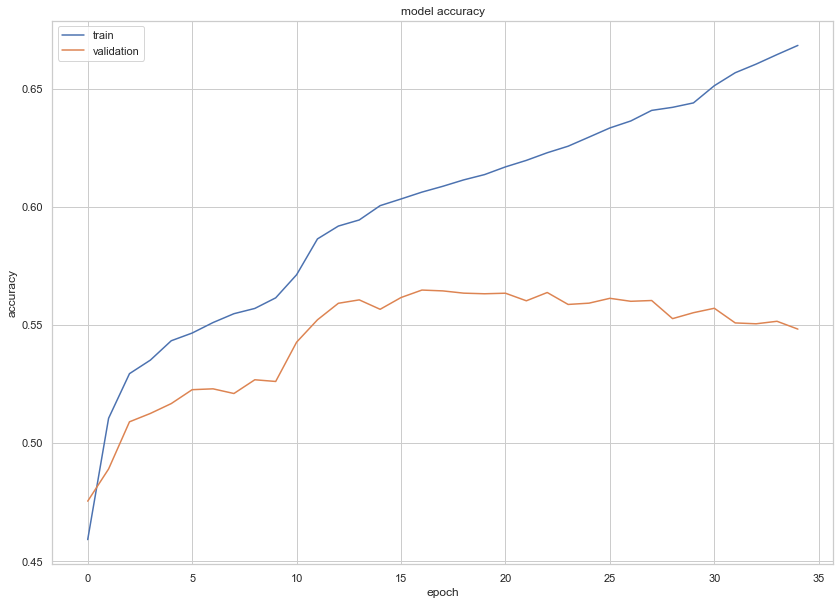

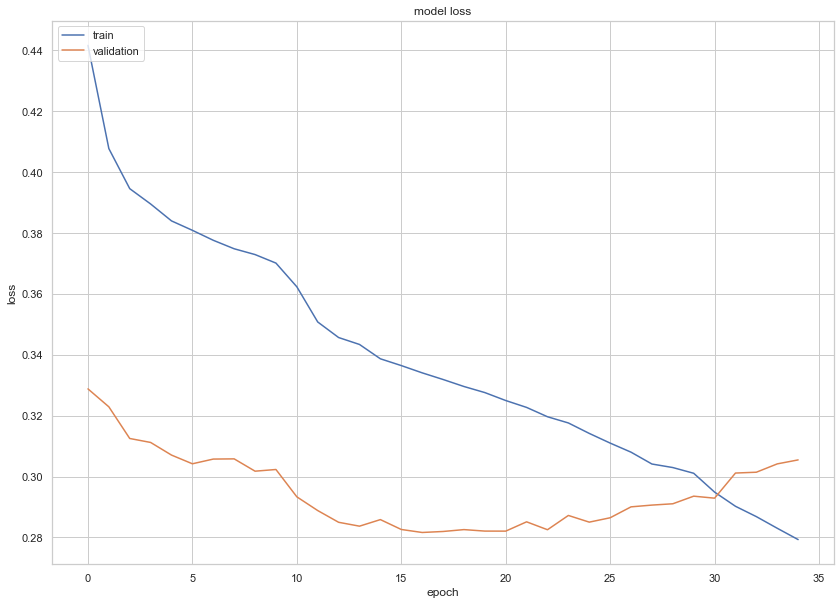

In [131]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

# "Accuracy"
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config2Accuracy.png', dpi=1200)

# "Loss"
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config2Loss.png', dpi=1200)

# DeepStruct Model Candidate 3 (Protein Profiles)
## - Best Validation Accuracy is 67.50%
This model uses protein profiles instead of the sequence. What does it use? PSI-BLAST? Who Knows, this dataset is kinda non descriptive <br>
Note: We first load the data, with the AA profiles (35:56) instead of the AA Name (0:21).

In [2]:
file = gzip.GzipFile("datasets/cullpdb+profile_5926_filtered.npy.gz", "r")
pdbs = np.load(file)
data = pdbs.reshape((len(pdbs), 700, 57))
x = data[:, :, 35:56]
y = data[:, :, 22:30]
print("Total Training Datapoints = {} ".format(len(data)))
print("Training Inputs Shape = {}".format(x.shape))
print("Training Outputs Shape = {}\n".format(y.shape))

test_file = gzip.GzipFile("datasets/cb513+profile_split1.npy.gz", "r")
test_pdbs = np.load(test_file)
test_data = test_pdbs.reshape((514, 700, 57))
test_x = test_data[:, :, 35:56]
test_y = test_data[:, :, 22:30]
print("Total Testing Datapoints = {} ".format(len(data)))
print("Testing Inputs Shape = {}".format(x.shape))
print("Testing Outputs Shape = {}\n".format(y.shape))

Total Training Datapoints = 5365 
Training Inputs Shape = (5365, 700, 21)
Training Outputs Shape = (5365, 700, 8)

Total Testing Datapoints = 5365 
Testing Inputs Shape = (5365, 700, 21)
Testing Outputs Shape = (5365, 700, 8)



In [5]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(700, 21)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',  'mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 700, 21)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 700, 256)          153600    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 700, 256)          394240    
_________________________________________________________________
dense_5 (Dense)              (None, 700, 64)           16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 700, 64)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 700, 32)           2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 700, 32)          

In [4]:
history = model.fit(x, y, epochs=40, validation_data = (test_x, test_y), batch_size=32)
model.save_weights("models/DeepStructModelCandidate3ProteinProfile.h5")
file = open("models/DeepStructModelCandidate3ProteinProfile.history", "wb+")
pickle.dump(history.history, file)

Train on 5365 samples, validate on 514 samples
Epoch 1/40
  64/5365 [..............................] - ETA: 15:06 - loss: 0.5740 - acc: 0.2112 - mae: 0.2179

KeyboardInterrupt: 

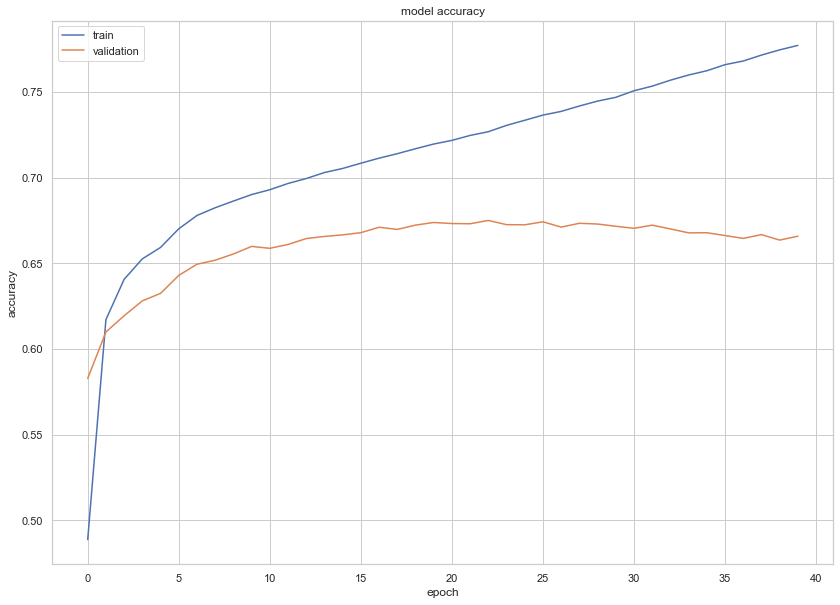

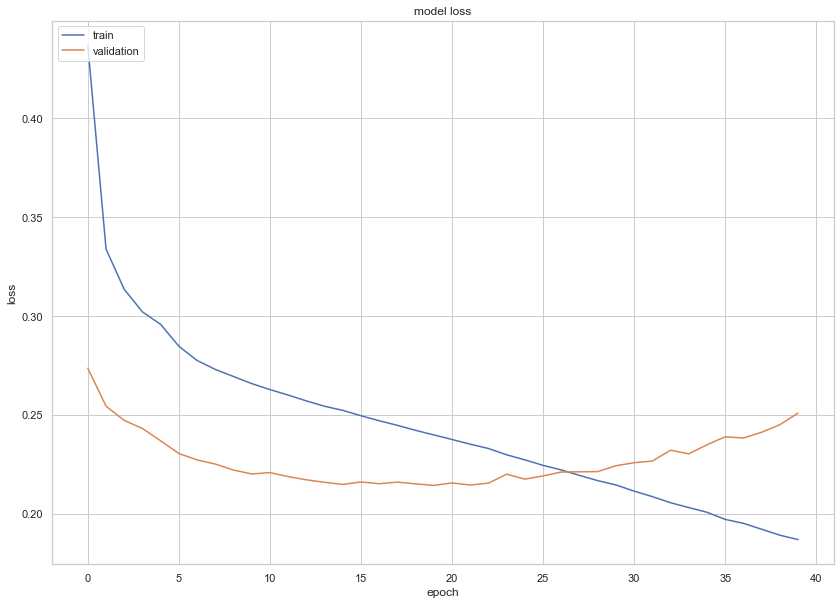

In [159]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

# "Accuracy"
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config3Accuracy.png', dpi=1200)

# "Loss"
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config3Loss.png', dpi=1200)

# DeepStruct Model Candidate 4 
## - Best Validation Accuracy is 67.39% (Global Best = 67.50%)

In [190]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(700, 21)))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',  'mae'])

In [ ]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
history = model.fit(x, y, epochs=100, validation_data = (test_x, test_y), batch_size=32, callbacks=[es])
model.save_weights("models/DeepStructModelCandidate4ProteinProfile.h5")
file = open("models/DeepStructModelCandidate4ProteinProfile.history", "wb+")
pickle.dump(history.history, file)

Train on 5365 samples, validate on 514 samples
Epoch 1/100
5365/5365 [==============================] - 525s 98ms/step - loss: 1.1563 - acc: 0.4078 - mae: 0.1777 - val_loss: 0.7195 - val_acc: 0.4497 - val_mae: 0.1599
Epoch 2/100
5365/5365 [==============================] - 519s 97ms/step - loss: 0.7020 - acc: 0.5518 - mae: 0.1440 - val_loss: 0.5564 - val_acc: 0.5422 - val_mae: 0.1421
Epoch 3/100
5365/5365 [==============================] - 582s 108ms/step - loss: 0.5781 - acc: 0.5775 - mae: 0.1371 - val_loss: 0.4624 - val_acc: 0.5609 - val_mae: 0.1433
Epoch 4/100
5365/5365 [==============================] - 630s 118ms/step - loss: 0.4960 - acc: 0.5915 - mae: 0.1338 - val_loss: 0.3932 - val_acc: 0.5753 - val_mae: 0.1393
Epoch 5/100
5365/5365 [==============================] - 591s 110ms/step - loss: 0.4399 - acc: 0.6006 - mae: 0.1316 - val_loss: 0.3490 - val_acc: 0.5814 - val_mae: 0.1377
Epoch 6/100
5365/5365 [==============================] - 1285s 239ms/step - loss: 0.4028 - acc: 0.60

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

# "Accuracy"
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config4Accuracy.png', dpi=1200)

# "Loss"
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('images/Config4Loss.png', dpi=1200)